In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
from sklearn.utils.extmath import cartesian
from geopy.distance import geodesic

In [2]:
def preprocess_trips(trips_df):

    trips_df.dropna(inplace=True)
    
    cols_to_drop = ["bike_type", "passholder_type", "trip_route_category", "plan_duration"]
    trips_df.drop(cols_to_drop, axis=1, inplace=True) 

    locations = trips_df['start_station'].unique()
    new_ids = list(range(len(locations)))
    mapping = dict(zip(locations, new_ids))

    trips_df['start_station'] = trips_df['start_station'].map(mapping)
    trips_df['end_station'] = trips_df['end_station'].map(mapping)

    trips_df["start_time"] = pd.to_datetime(trips_df["start_time"], format="%m/%d/%Y %H:%M")
    trips_df["end_time"] = pd.to_datetime(trips_df["end_time"], format="%m/%d/%Y %H:%M")

    trips_df = trips_df.sort_values(by="start_time")
    
    return trips_df

In [3]:
trips = pd.read_csv("../Data/bikeshare-data/bikeshare-test.csv")
#rips.head()

In [4]:
preprocess_trips(trips)

,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id
0,249955060,41,2023-04-01 00:00:00,2023-04-01 00:41:00,0,34.072620,-118.449440,0.0,34.072620,-118.449440,22398
1,249954734,11,2023-04-01 00:00:00,2023-04-01 00:11:00,0,34.072620,-118.449440,7.0,34.069752,-118.445351,22304
2,249954667,2,2023-04-01 00:02:00,2023-04-01 00:04:00,1,34.068748,-118.309280,4.0,34.065430,-118.308823,6591
3,249954776,12,2023-04-01 00:03:00,2023-04-01 00:15:00,2,34.042061,-118.263382,101.0,34.047440,-118.247940,13897
4,249954777,11,2023-04-01 00:04:00,2023-04-01 00:15:00,3,34.037460,-118.265381,101.0,34.047440,-118.247940,15488
...,...,...,...,...,...,...,...,...,...,...,...
109430,276579645,11,2023-06-30 23:39:00,2023-06-30 23:50:00,31,34.051102,-118.264557,31.0,34.051102,-118.264557,30593
109431,276590585,23,2023-06-30 23:44:00,2023-07-01 00:07:00,213,34.056969,-118.253593,213.0,34.056969,-118.253593,6205
109432,276579686,9,2023-06-30 23:45:00,2023-06-30 23:54:00,217,34.050140,-118.233192,217.0,34.050140,-118.233192,13851
109434,276590620,14,2023-06-30 23:55:00,2023-07-01 00:09:00,59,34.014309,-118.491341,102.0,33.996239,-118.477448,15658


trips.dropna(inplace=True)
#trips.head()

locations = trips['start_station'].unique()
new_ids = list(range(len(trips['start_station'].unique())))
mapping = dict(zip(locations, new_ids))

trips['start_station'] = trips['start_station'].map(mapping)
trips['end_station'] = trips['end_station'].map(mapping)

cols_to_drop = ["bike_type", "passholder_type", "trip_route_category", "plan_duration"]
trips_df.drop(cols_to_drop, axis=1, inplace=True) 

#trips.head()

trips = trips.sort_values(by="start_time")
#trips.head()

<Axes: xlabel='index', ylabel='trips_per_hour'>

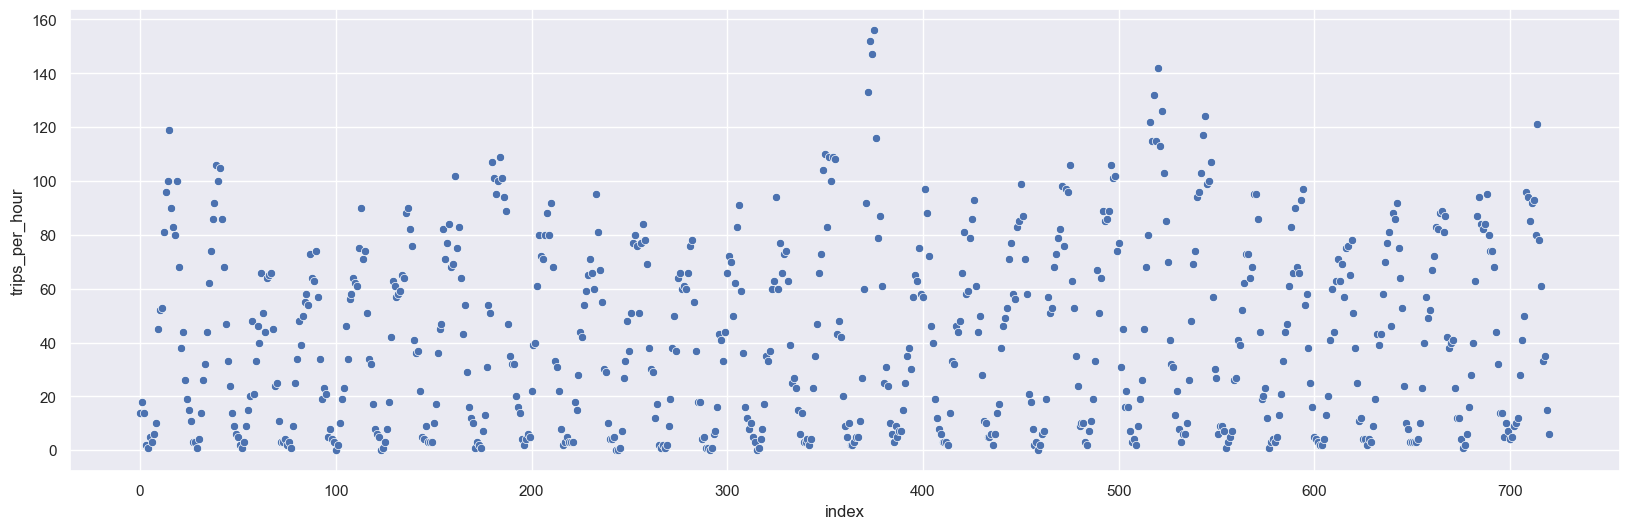

In [20]:
sns.set(rc={'figure.figsize':(20,6)})

trips["start_time"] = pd.to_datetime(trips["start_time"], format="%m/%d/%Y %H:%M")
trips["end_time"] = pd.to_datetime(trips["end_time"], format="%m/%d/%Y %H:%M")

start_date = datetime.strptime("4/1/2023 0:00", "%m/%d/%Y %H:%M")
end_date = datetime.strptime("5/1/2023 0:00", "%m/%d/%Y %H:%M")
interval = timedelta(minutes=60)
bucket_elements = []
while start_date <= end_date:
    bucket_elements.append(trips[((start_date + interval) >= trips["end_time"])
                                & (start_date <= trips["end_time"])].shape[0])
    start_date += interval

sns.scatterplot(x="index", y="trips_per_hour", data=pd.DataFrame(bucket_elements, columns=["trips_per_hour"]).reset_index())

In [15]:
outgoing_trips = trips.groupby("start_station").count()["bike_id"].values
incoming_trips = trips.groupby("end_station").count()["bike_id"].values

all_station_ids = set(trips["start_station"].unique()) | set(trips["end_station"].unique())

outgoing_trips = np.pad(outgoing_trips, (0, len(all_station_ids) - len(outgoing_trips)), mode='constant')
incoming_trips = np.pad(incoming_trips, (0, len(all_station_ids) - len(incoming_trips)), mode='constant')

outgoing_trips = (outgoing_trips - np.min(outgoing_trips)) / (np.max(outgoing_trips) - np.min(outgoing_trips))
incoming_trips = (incoming_trips - np.min(incoming_trips)) / (np.max(incoming_trips) - np.min(incoming_trips))

node_features = np.stack([outgoing_trips, incoming_trips]).transpose()
print("Full shape: ", node_features.shape)
node_features[:10] 


Full shape:  (231, 2)


array([[0.24391063, 0.18240691],
       [0.04888292, 0.05540565],
       [0.09474215, 0.1122504 ],
       [0.06870485, 0.06457996],
       [0.05996976, 0.0687174 ],
       [1.        , 0.90106134],
       [0.05022678, 0.04353301],
       [0.19385184, 0.22396114],
       [0.08499916, 0.09372189],
       [0.28590627, 0.31804281]])

In [16]:
subset = ["start_lon", "start_lat", "start_station"]
all_starts = trips.drop_duplicates(subset="start_station", keep="first")[subset]
subset = ["end_lon", "end_lat", "end_station"]
all_ends = trips.drop_duplicates(subset="end_station", keep="first")[subset]
distance_matrix = all_ends.merge(all_starts, how="cross")
distance_matrix["distance"] = distance_matrix.apply(lambda x: geodesic((x["start_lat"], x["start_lon"]), 
                                                        (x["end_lat"], x["end_lon"])).meters, axis=1)
#distance_matrix.head()

In [8]:
distance_matrix["edge"] = distance_matrix["distance"] < 500
#distance_matrix.head()

In [9]:
edge_index = distance_matrix[distance_matrix["edge"] == True][["start_station", "end_station"]].values
edge_index = edge_index.transpose()
#edge_index

In [10]:
distance_feature = distance_matrix[distance_matrix["edge"] == True]["distance"].values
edge_type_feature = np.zeros_like(distance_feature)
trip_duration_feature = np.zeros_like(distance_feature)
static_edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose()
#static_edge_features

In [11]:
def extract_dynamic_edges(s):

    trip_indices = s[["start_station", "end_station"]].values
    trip_durations = s["duration"]


    distance_feature  = pd.DataFrame(trip_indices, 
                                    columns=["start_station", "end_station"]).merge(
                                        distance_matrix, on=["start_station", "end_station"], 
                                        how="left")["distance"].values
    edge_type_feature = np.ones_like(distance_feature) 
    trip_duration_feature = trip_durations
    edge_features = np.stack([distance_feature, edge_type_feature, trip_duration_feature]).transpose()
    return edge_features, trip_indices.transpose()

In [12]:
start_date = datetime.strptime("4/1/2023 0:00", "%m/%d/%Y %H:%M")
end_date = datetime.strptime("5/1/2023 0:00", "%m/%d/%Y %H:%M")

interval = timedelta(minutes=60)

xs = []
edge_indices = []
ys = []
y_indices = []
edge_features = []


while start_date <= end_date:
    # 0 - 60 min 
    current_snapshot = trips[((start_date + interval) >= trips["end_time"])
                                & (start_date <= trips["end_time"])]
    # 60 - 120 min
    subsequent_snapshot = trips[((start_date + 2*interval) >= trips["end_time"])
                                & (start_date + interval <= trips["end_time"])]
    current_snapshot = current_snapshot.groupby(["start_station", "end_station"]).mean().reset_index()
    subsequent_snapshot = subsequent_snapshot.groupby(["start_station", "end_station"]).mean().reset_index()

    edge_feats, additional_edge_index = extract_dynamic_edges(current_snapshot)
    exteneded_edge_index = np.concatenate([edge_index, additional_edge_index], axis=1)
    extended_edge_feats = np.concatenate([edge_feats, static_edge_features], axis=0)

    y = subsequent_snapshot["duration"].values
    y_index = subsequent_snapshot[["start_station", "end_station"]].values

    xs.append(node_features)
    edge_indices.append(exteneded_edge_index) 
    edge_features.append(extended_edge_feats)
    ys.append(y) 
    y_indices.append(y_index.transpose()) 

    start_date += interval

In [13]:
i = 4
print(f"""Example of graph snapshot {i}: \n
    Node feature shape: {xs[i].shape} \n
    Edge index shape: {edge_indices[i].shape} \n
    Edge feature shape: {edge_features[i].shape} \n 
    Labels shape: {ys[i].shape} \n
    Labels mask shape: {y_indices[i].shape}
    """)

Example of graph snapshot 4: 

    Node feature shape: (230, 2) 

    Edge index shape: (2, 703) 

    Edge feature shape: (703, 3) 
 
    Labels shape: (5,) 

    Labels mask shape: (2, 5)
    


In [14]:
from torch_geometric_temporal.signal import DynamicGraphTemporalSignal
dataset = DynamicGraphTemporalSignal(
            edge_indices, edge_features, xs, ys, y_indices=y_indices
        )

In [17]:
dataset